# Degree Tuning

In [21]:
!pip install pandas
!pip install sklearn

import pandas as pd;
import numpy as np;
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler;
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# empty list to append metric values
mae_gen = []
mse_gen  =[]
rmse_gen = []
mae_nor = []
mae_spi = []
mse_nor = []
mse_spi = []
rmse_nor = []
rmse_spi = []

# Data set processing and tuning:

In [22]:
# import data
data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

# 2018 data - 6 months
data = data.loc[data.index > 2018070000, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# assign degree range to loop
degree_range = [2, 3, 4]

# loop
for i in degree_range:
    
    # Divide features and labels
    X = data.iloc[:, 0:15]
    y = data.loc[:, 'Offers']

    # fill nan values
    X.fillna(X.mean(), inplace = True)
    y.fillna(y.mean(), inplace = True)

    # small fix
    X = X.astype('float64')
    X = X.round(20)

    # divide data into train and test with 15% test data
    X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size = 0.075, shuffle=False)

    # feature scaling
    sc_X = MinMaxScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)

    poly_reg = PolynomialFeatures(degree = i)
    X_train = poly_reg.fit_transform(X_train)

    # fit linear regression module to the matrix
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    
    # predict for X_test  
    y_pred = regressor.predict(poly_reg.fit_transform(X_test))

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mse_error = mse(y_test, y_pred) # 1479.61335
    mae_error = mae(y_test, y_pred) # 23.1525
    
    rmse_gen.append(rmse_error)
    mse_gen.append(mse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    
    # smal adjustment
    y_test.replace(0, 0.0001,inplace = True)

    
    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mse_spike = mse(y_test_spike, y_pred_spike)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mse_spi.append(mse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mse_normal = mse(y_test_normal, y_pred_normal)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mse_nor.append(mse_normal)
    mae_nor.append(mae_normal)



C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\Users\maria\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


# Results:

In [23]:
results = pd.DataFrame({                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor}, index = degree_range)

results

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
2,38.292674,27.229945,68.135932,55.362894,31.41009,22.980697
3,264.566704,58.395823,145.122851,75.265885,278.18474,55.847740
4,2776.170203,359.280400,1351.510594,273.978253,2931.77891,372.164577


# Highlight best results:

In [24]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
2,38.292674,27.229945,68.135932,55.362894,31.410090,22.980697
3,264.566704,58.395823,145.122851,75.265885,278.184740,55.847740
4,2776.170203,359.280400,1351.510594,273.978253,2931.778910,372.164577


In [25]:
!pip install matplotlib

# Plot results:

<IPython.core.display.Javascript object>


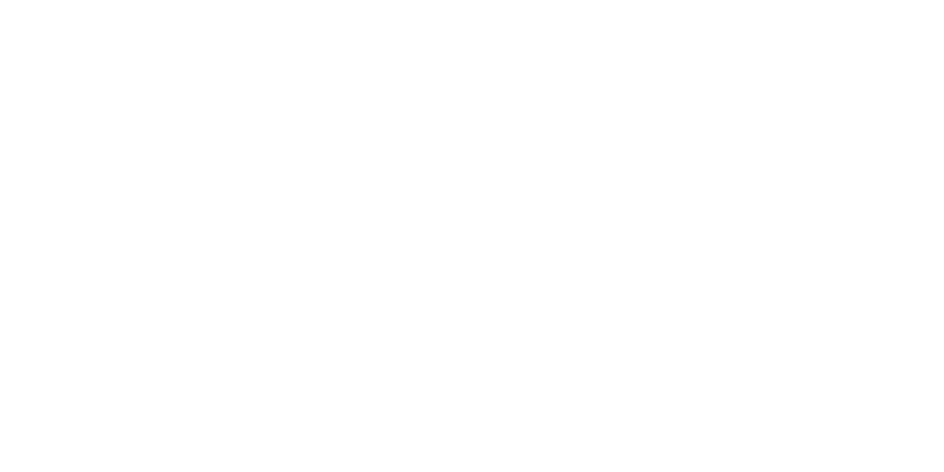

<IPython.core.display.Javascript object>


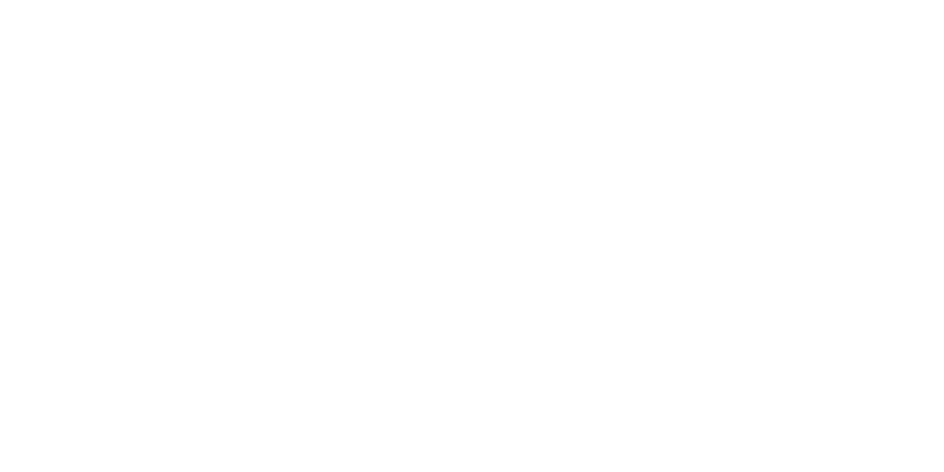

<IPython.core.display.Javascript object>


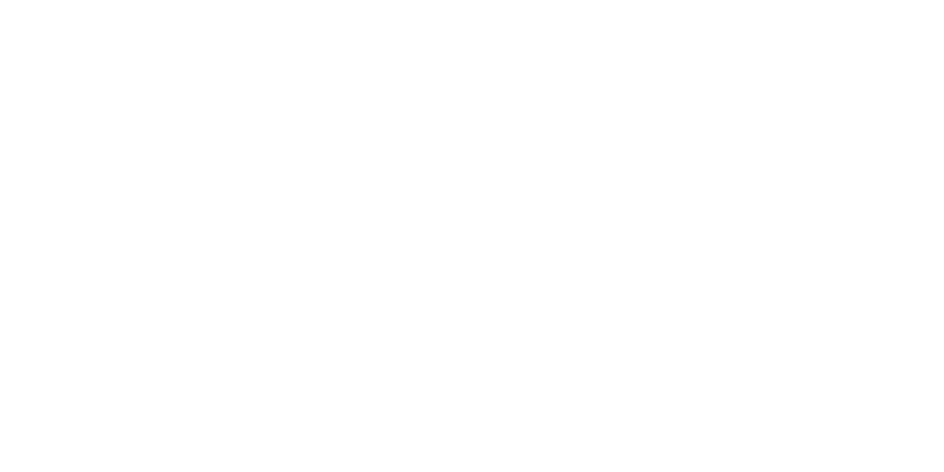

In [26]:
%matplotlib notebook

import matplotlib.pyplot as plt

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Polynomial Regression: Averaged RMSE on all test set \n for different degrees')
plt.scatter(x = list(range(len(rmse_gen))), y = rmse_gen, label = 'Overall error')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Degree number')
plt.xticks(list(range(len(rmse_gen))), degree_range)
plt.tight_layout()
plt.savefig('RMSE_best_degree_all_2.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Polynomial Regression: Averaged RMSE on spike regions \n for different degrees')
plt.scatter(x = list(range(len(rmse_gen))), y = rmse_spi, label = 'Spike regions', color = 'orange')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Degree number')
plt.xticks(list(range(len(rmse_gen))), degree_range)
plt.tight_layout()
plt.savefig('RMSE_best_degree_spike_2.png')


plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Polynomial Regression: Averaged RMSE on normal regions \n for different degrees')
plt.scatter(x = list(range(len(rmse_gen))), y =rmse_nor, label = 'Normal regions', color = 'green')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Degree number')
plt.xticks(list(range(len(rmse_gen))), degree_range)
plt.tight_layout()
plt.savefig('RMSE_best_degree_normal_2.png')

<IPython.core.display.Javascript object>


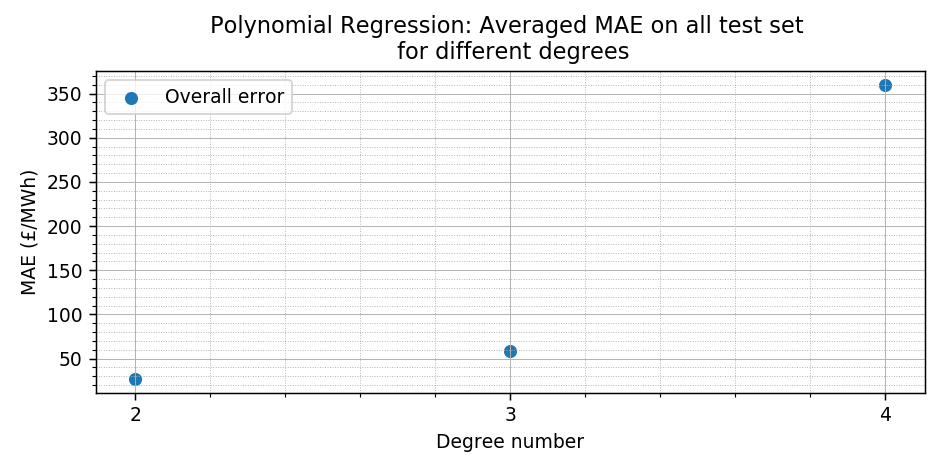

<IPython.core.display.Javascript object>


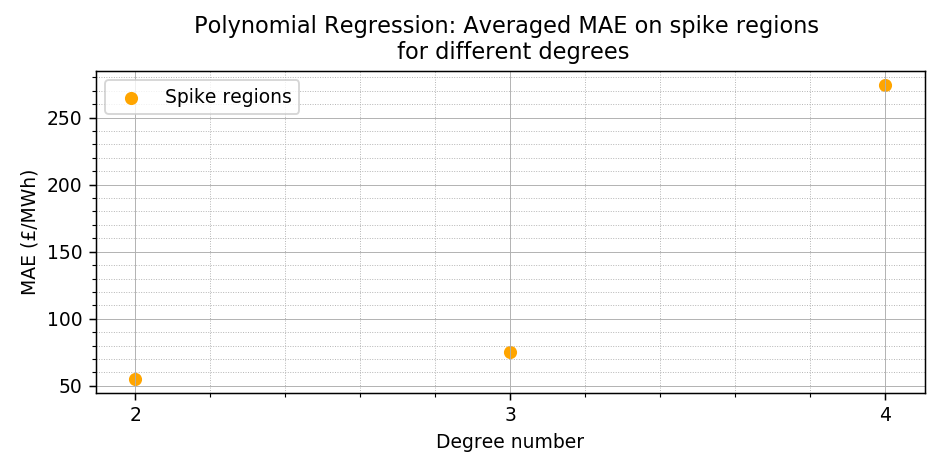

<IPython.core.display.Javascript object>


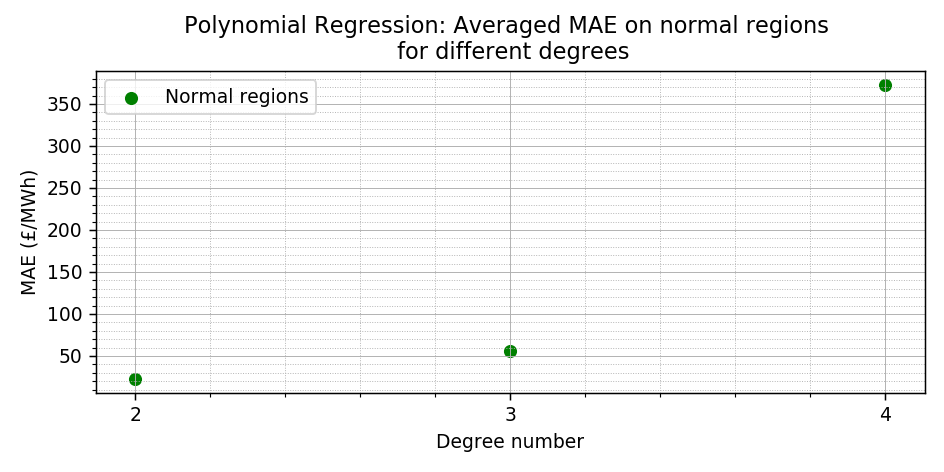

In [27]:
%matplotlib notebook

import matplotlib.pyplot as plt

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Polynomial Regression: Averaged MAE on all test set \n for different degrees')
plt.scatter(x = list(range(len(mae_gen))), y = mae_gen, label = 'Overall error')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Degree number')
plt.xticks(list(range(len(mae_gen))), degree_range)
plt.tight_layout()
plt.savefig('MAE_best_degree_all_2.png')

plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Polynomial Regression: Averaged MAE on spike regions \n for different degrees')
plt.scatter(x = list(range(len(mae_gen))), y = mae_spi, label = 'Spike regions', color = 'orange')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Degree number')
plt.xticks(list(range(len(mae_gen))), degree_range)
plt.tight_layout()
plt.savefig('MAE_best_degree_spike_2.png')


plt.figure(figsize=(7,3.5))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Polynomial Regression: Averaged MAE on normal regions \n for different degrees')
plt.scatter(x = list(range(len(mae_gen))), y = mae_nor, label = 'Normal regions', color = 'green')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Degree number')
plt.xticks(list(range(len(mae_gen))), degree_range)
plt.tight_layout()
plt.savefig('MAE_best_degree_normal_2.png')